In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os

### **PART 1:**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Architecture of VGG16:**

A convolutional neural network is also known as a ConvNet, which is a kind of artificial neural network. A convolutional neural network has an input layer, an output layer, and various hidden layers. VGG16 is a type of CNN (Convolutional Neural Network) that is considered to be one of the best computer vision models to date. The creators of this model evaluated the networks and increased the depth using an architecture with very small (3 × 3) convolution filters, which showed a significant improvement on the prior-art configurations. They pushed the depth to 16–19 weight layers making it approx — 138 trainable parameters.
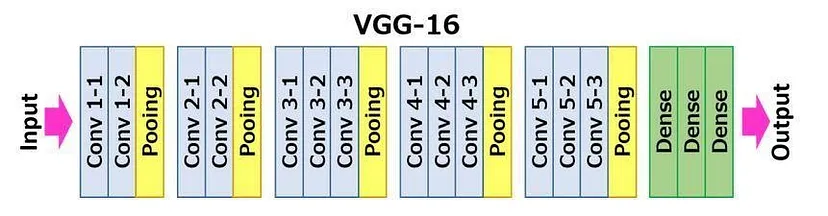


![0_0M8CobXpNwFDCmOQ.webp](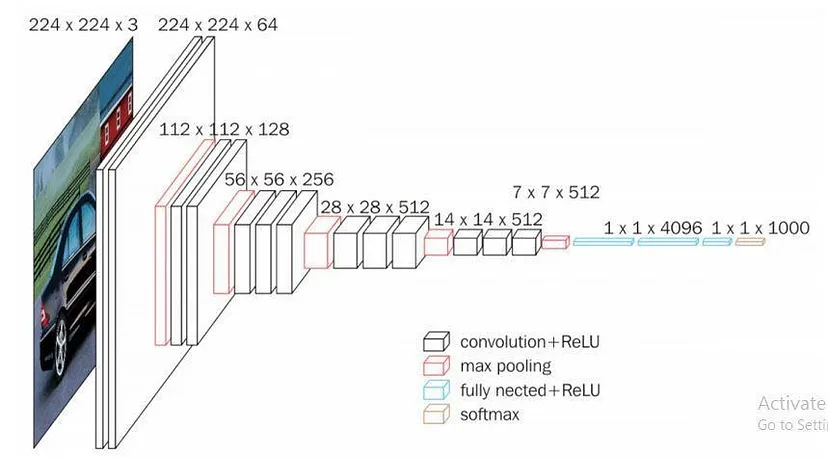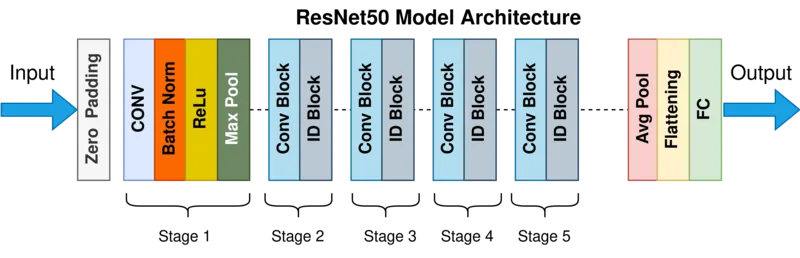)

Most unique thing about VGG16 is that instead of having a large number of hyper-parameters they focused on having convolution layers of 3x3 filter with stride 1 and always used the same padding and maxpool layer of 2x2 filter of stride 2.

source:https://medium.com/@pouyahallaj/data-augmentation-benefits-and-disadvantages-38d8201aead

### **Architecture of Resnet50**

ResNet50 is a powerful image classification model that can be trained on large datasets and achieve state-of-the-art results. One of its key innovations is the use of residual connections, which allow the network to learn a set of residual functions that map the input to the desired output. These residual connections enable the network to learn much deeper architectures than was previously possible, without suffering from the problem of vanishing gradients.

The architecture of ResNet50 is divided into four main parts: the convolutional layers, the identity block, the convolutional block, and the fully connected layers. The convolutional layers are responsible for extracting features from the input image, while the identity block and convolutional block are responsible for processing and transforming these features. Finally, the fully connected layers are used to make the final classification.

The convolutional layers in ResNet50 consist of several convolutional layers followed by batch normalization and ReLU activation. These layers are responsible for extracting features from the input image, such as edges, textures, and shapes. The convolutional layers are followed by max pooling layers, which reduce the spatial dimensions of the feature maps while preserving the most important features.

The identity block and convolutional block are the key building blocks of ResNet50. The identity block is a simple block that passes the input through a series of convolutional layers and adds the input back to the output. This allows the network to learn residual functions that map the input to the desired output. The convolutional block is similar to the identity block, but with the addition of a 1x1 convolutional layer that is used to reduce the number of filters before the 3x3 convolutional layer.

The final part of ResNet50 is the fully connected layers. These layers are responsible for making the final classification. The output of the final fully connected layer is fed into a softmax activation function to produce the final class probabilities.

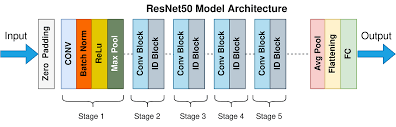

### **Code Example without data augmentation**

here I used ImageDataGenerator form keras.preprocessing.I just rescaled the photo and didn't change anything else.I load all my images in one batch and I choose a seed because in all the loadings my sample be the same

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)
folder1_path = '/content/drive/MyDrive/Data-Dermoscopic _Images (1)/Carcinoma'  # Replace with the actual path to your folder
folder2_path = '/content/drive/MyDrive/Data-Dermoscopic _Images (1)/Melanoma'  # Replace with the actual path to your folder
folder3_path = '/content/drive/MyDrive/Data-Dermoscopic _Images (1)/Nevus'  # Replace with the actual path to your folder
dataset = datagen.flow_from_directory(
    directory='/content/drive/MyDrive/Data-Dermoscopic _Images (1)',  # Replace with the path to the parent folder
    class_mode='categorical',
   #target_size=(224, 224),  # Set the desired target size of the images
    batch_size=173,  # Adjust batch_size according to your memory constraints
    shuffle=True,
    seed=42
)


Found 173 images belonging to 3 classes.


The ImageDataGenerator return a iterator.using next,I load all of images and labels.

In [7]:
images, labels = next(iter(dataset))

I shuffle the dataset the I used test train split from sklearn to seperate the in to two groups.training data and test data

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
images, labels = shuffle(images, labels, random_state=1)

train_x, test_x, train_y, test_y = train_test_split(images, labels, test_size=0.30, random_state=415)

here i show one of the images to be sure that images are in the dataset

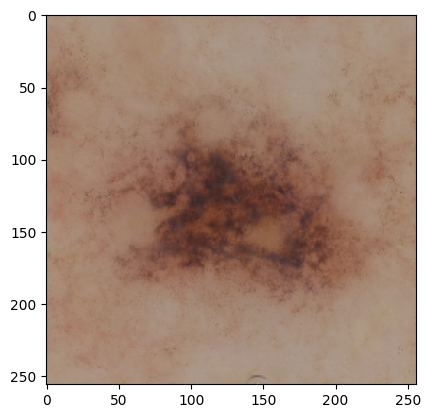

In [11]:
import matplotlib.pyplot as plt
plt.imshow(train_x[1])

here i load the VGG16.I didn't include the top layer.I used the model trained on imagenet for better results becuase we don't have enough data

In [12]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load pre-trained model without the top (fully connected) layers
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(256, 256, 3))
for layer in base_model.layers:
    layer.trainable = False
# Freeze the pre-trained layers



58889256/58889256 [==============================] - 3s 0us/step


here i added my own top layer.in last layer I used softmax activation function for 3 groups.

using Model I've put inputs of base_model as inputs to my model and output of softmax activiation function as the output of the model.

In [13]:
tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = Flatten()(base_model.output)
x =tf.keras.layers.Dropout(0.5)(x)
x=tf.keras.layers.BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x =tf.keras.layers.Dropout(0.5)(x)
x=tf.keras.layers.BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x =tf.keras.layers.Dropout(0.5)(x)
x=tf.keras.layers.BatchNormalization()(x)
x = Dense(100, activation='relu')(x)
x =tf.keras.layers.Dropout(0.5)(x)
x=tf.keras.layers.BatchNormalization()(x)
x = Dense(100, activation='relu')(x)

output = Dense(3, activation='softmax')(x)  # num_classes is the number of classes in your dataset
model_vgg = Model(inputs=base_model.input, outputs=output)


I used model.summary to see the summary of the model

In [ ]:
model_vgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

Print loss and print accuracy are my own functions to print accuracy and loss.it gets the history dataframe and plot the columns for loss and accuracy

In [14]:
def print_loss(history):
  history_df = pd.DataFrame(history.history)
  history_df.loc[:, ['loss', 'val_loss']].plot();
  print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

In [9]:
def print_accuracy(history) :

  history_df = pd.DataFrame(history.history)
  history_df.loc[:, ['accuracy', 'val_accuracy']].plot();
  print("maximu validation accuracy: {}".format(history_df['val_accuracy'].max()))

here I compiled the model.using Adam optimizer with 0.0001 learning rate.when loadinf data,I used the variable to one hot encode the labels so I used categorial crossentropy

In [ ]:
model_vgg.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

I used 90 epochs to train the model and the batch size is 10.

In [ ]:
#model_vgg.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

history_VGG16_withoutaug=model_vgg.fit(x=train_x,y=train_y,validation_data=(test_x,test_y), epochs=90,verbose=1,batch_size=10)

Here i plot the accuracy during epochs and as you can see the results are not good.

In [ ]:
print_accuracy(history_VGG16_withoutaug)

Here i plotted the loss and it does not seem good!

In [ ]:
print_loss(history_VGG16_withoutaug)

for making classification report, i should first convert labels to not one hot encoded.then I use model.predict to obtain the probablities(remember we use softmax activation function).I should find the highest probablity and assign the label.Then using predicted labels, we obtain the classification report

in print report I visualize the report for better understanding

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
def make_report(y_test,X_test,model,target_labels):
# Generate the classification report
  y_test=np.argmax(y_test, axis=1)
  y_pred_probs=model.predict(X_test)
  y_pred = np.argmax(y_pred_probs, axis=1)
  report = classification_report(y_test, y_pred, target_names=target_labels, output_dict=True)
  report_df = pd.DataFrame(report).transpose()
  return report_df

def print_report(report_df):
  plt.figure(figsize=(8, 5))
  sns.heatmap(report_df.iloc[:-1, :].T, annot=True, cmap="YlGnBu", fmt=".2f", cbar=False)
  plt.title("Classification Report")
  plt.xlabel("Metrics")
  plt.ylabel("Classes")
  plt.show()

As you can see in the report,the f1 score is not bad.But we have to compare them with the case with data augmentation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
#make_report(y_test,X_test,model,target_labels)

print_report(make_report(test_y,test_x,model_vgg,[0,1,2]))
#)


I did the same thing for resnet50

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load pre-trained model without the top (fully connected) layers
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(256, 256, 3))

for layer in base_model.layers:
    layer.trainable = False

I did the same procedure.I added some layers myself.like the previous case,I used softmax activiation function with 3 outputs.

In [ ]:
x = Flatten()(base_model.output)
x =tf.keras.layers.Dropout(0.5)(x)
x=tf.keras.layers.BatchNormalization()(x)
x = Dense(100, activation='relu')(x)
x =tf.keras.layers.Dropout(0.5)(x)
x=tf.keras.layers.BatchNormalization()(x)
x = Dense(100, activation='relu')(x)
x =tf.keras.layers.Dropout(0.5)(x)
x=tf.keras.layers.BatchNormalization()(x)
x = Dense(100, activation='relu')(x)
x =tf.keras.layers.Dropout(0.5)(x)
#

output = Dense(3, activation='softmax')(x)  # num_classes is the number of classes in your dataset
model_ResNet50 = Model(inputs=base_model.input, outputs=output)

I compiled and run the model.I used rmsprop as optimizer because it worked better than adam

In [ ]:
from tensorflow.keras.optimizers import RMSprop
model_ResNet50.compile(optimizer=RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

Resnet_without_augment=model_ResNet50.fit(x=train_x,y=train_y,validation_data=(test_x,test_y), epochs=90,verbose=1,batch_size=10)

I printed the accuracy plot of the model.our accuracy is increasing but it is diverging and it has lot of noise

In [ ]:
print_accuracy(Resnet_without_augment)

we printed the loss function and it obviously overfit becuase the loss of validation data is increasing

In [ ]:
print_loss(Resnet_without_augment)

I talked about how to plot the classification report.as you can see the f1 score is not really high

In [ ]:
print_report(make_report(test_y,test_x,model_ResNet50,[0,1,2]))

### **code example with data augmentation**

I used ImageDataGenerator function of tensorflow.keras.preprocessing.This function changes some attribute of the picture like it shifts the width or zoom it out depending on the variables we pass.The using .flow we apply it to our data.We pass the batch of our data.We need to have steps per epoch which is depending on the number of picture in each batch.We can do simple division and use the ceil of the output.

Then using .fit_generator I pass the generated test and train images to my model.

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.optimizers import RMSprop
# Create an instance of the ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=None,  # Randomly rotate the images by up to 20 degrees
    width_shift_range=0.1,  # Randomly shift the width by up to 10%
    height_shift_range=0.1,  # Randomly shift the height by up to 10%
    shear_range=0.2,  # Randomly apply shearing transformations
    zoom_range=0.2,  # Randomly zoom in and out
    horizontal_flip=True,  # Randomly flip the images horizontally
    vertical_flip=True,  # Randomly flip the images vertically
    fill_mode='nearest'  # Fill any newly created pixels after rotation or shifting
)

# Generate augmented images
train_gen=datagen.flow(train_x,train_y,30)
val_gen=datagen.flow(test_x,test_y,10)
steps_per_epoch_train=train_x.shape[0]//30
steps_per_epoch_val=test_x.shape[0]//10



here i compiled the model again and I use another optimizer for training

In [16]:
model_vgg.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
after_augment_vgg=model_vgg.fit_generator(train_gen,steps_per_epoch=steps_per_epoch_train,epochs=200, validation_data = val_gen,validation_steps=steps_per_epoch_val)


<ipython-input-16-5968f507d687>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after_augment_vgg=model_vgg.fit_generator(train_gen,steps_per_epoch=steps_per_epoch_train,epochs=200, validation_data = val_gen,validation_steps=steps_per_epoch_val)


Epoch 1/200
4/4 [==============================] - 26s 2s/step - loss: 1.2893 - accuracy: 0.3077 - val_loss: 1.0947 - val_accuracy: 0.3000
Epoch 2/200
4/4 [==============================] - 2s 642ms/step - loss: 1.2469 - accuracy: 0.3077 - val_loss: 1.0995 - val_accuracy: 0.3200
Epoch 3/200
4/4 [==============================] - 3s 660ms/step - loss: 1.2913 - accuracy: 0.3516 - val_loss: 1.0894 - val_accuracy: 0.3600
Epoch 4/200
4/4 [==============================] - 2s 631ms/step - loss: 1.2514 - accuracy: 0.2747 - val_loss: 1.0845 - val_accuracy: 0.5400
Epoch 5/200
4/4 [==============================] - 3s 736ms/step - loss: 1.2005 - accuracy: 0.4835 - val_loss: 1.0893 - val_accuracy: 0.3400
Epoch 6/200
4/4 [==============================] - 4s 1s/step - loss: 1.1259 - accuracy: 0.4396 - val_loss: 1.0893 - val_accuracy: 0.3200
Epoch 7/200
4/4 [==============================] - 3s 682ms/step - loss: 1.2612 - accuracy: 0.2917 - val_loss: 1.1006 - val_accuracy: 0.3200
Epoch 8/200
4/4 [=

Here I printed the classification report.We see an obvious increase in f1 score recall precison and accuracy

In [ ]:
print_report(make_report(test_y,test_x,model_vgg,[0,1,2]))

even the accuracy plot is better.It diverges a lot but it increased over time

maximu validation accuracy: 0.8199999928474426


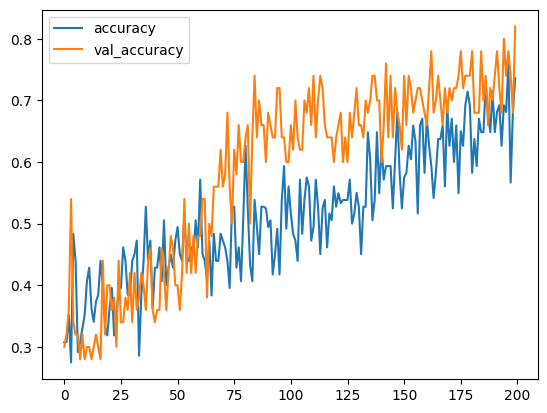

In [17]:
print_accuracy(after_augment_vgg)

and our loss is decreasing.so the model is better!

In [ ]:
print_loss(history_VGG16_withoutaug)

now we pass the generated train and test to resnet and we plot the
 classification report

In [ ]:
after_augment_resnet=model_ResNet50.fit_generator(train_gen,steps_per_epoch=steps_per_epoch_train,epochs=100, validation_data = val_gen,validation_steps=steps_per_epoch_val)

our f1 score and other methods are way better than resnet without data augmentaion! so we can conclude that data augmentation helps us develop better model!

in this for cases the VGG16 has the best f1 score.so we can conclude that VGG 16 with data augmentation is the best model to train this model!

In [ ]:
print_report(make_report(test_y,test_x,model_ResNet50,[0,1,2]))

I plot the accuracy and loss as always

In [ ]:
print_accuracy(after_augment_resnet)

In [ ]:
print_loss(after_augment_resnet)

There are some extra points to consider:

1-as you can see the resnet without augmentation works better than with augmentaion.sometime data augmentation worsens our model because it add noise to data.

2-each model works best on a different group.but at last the f1 score of vgg16  with augmentation is the highest.so it is the best model for this case.

3-I did not use accuracy to compare because I thought the f1 score is the better metrics here.

Advantages and disadvatages of data augmentation:

benefits:



Improved generalization: Data augmentation can help to improve a model’s generalization ability by making it more robust to different variations in the data. This is because the model is exposed to a wider variety of data during training.

Reduced overfitting: Data augmentation can also help to reduce overfitting, which is a common problem in machine learning. Overfitting occurs when a model learns the training data too well and is unable to generalize to new data. Data augmentation makes the training data more diverse, which helps to prevent the model from overfitting.

Increased accuracy: Data augmentation can often lead to improved accuracy on both the training and test sets. This is because the model is able to learn more robust features from a larger and more diverse dataset.

Reduced cost: Data augmentation can be a cost-effective way to increase the size and diversity of a training dataset, especially for tasks where collecting new data is expensive or time-consuming.

Disadvantages of data augmentation:
Increased computational cost:

Data augmentation can increase the computational cost of training a model, especially for deep learning models. This is because the model needs to be trained on a larger number of images.

Potential for introducing noise: If data augmentation is not used carefully, it can introduce noise into the training data. This can lead to decreased performance on the test set.

Limited effectiveness for certain tasks: Data augmentation may not be effective for certain tasks, such as tasks where the data is already very diverse.

### **PART2**

In [ ]:

# example of a dcgan on cifar10
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot


Here i defined the discriminator model.I have 4 conv2D layers.I used leakyRelu with alpha of 0.2 for eachlayer.at the end I flatten the layers and used sigmoid function.The discriminator should say if the photo is real or fake.

In [ ]:
def define_discriminator(in_shape=(32,32,3)):
 model = Sequential()
 # normal
 model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
 model.add(LeakyReLU(alpha=0.2))
 # downsample
 model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
 model.add(LeakyReLU(alpha=0.2))
 # downsample
 model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
 model.add(LeakyReLU(alpha=0.2))
 # downsample
 model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
 model.add(LeakyReLU(alpha=0.2))
 # classifier
 model.add(Flatten())
 model.add(Dropout(0.4))
 model.add(Dense(1, activation='sigmoid'))
 # compile model
 opt = Adam(lr=0.0002, beta_1=0.5)
 model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
 #model.trainable = False
 return model

This is the generator model.I give a noise as input.I use Conv2Dtranspose layers with 128 neurons.here I used the leakyRelu as the activation function.
conv2dTranspose() function is used to transposed convolutions which generally arises from the desire to use a transformation going in the opposite direction of a normal convolution

In [ ]:
def define_generator(latent_dim):
 model = Sequential()
 # foundation for 4x4 image
 n_nodes = 256 * 4 * 4
 model.add(Dense(n_nodes, input_dim=latent_dim))
 model.add(LeakyReLU(alpha=0.2))
 model.add(Reshape((4, 4, 256)))
 # upsample to 8x8
 model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
 model.add(LeakyReLU(alpha=0.2))
 # upsample to 16x16
 model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
 model.add(LeakyReLU(alpha=0.2))
 # upsample to 32x32
 model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
 model.add(LeakyReLU(alpha=0.2))
 # output layer
 model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
 return model

for Gan I passed both generator and discriminator model.I used Adam optimizer and I used binary cross entropy as loss function

In [ ]:
def define_gan(g_model, d_model):
 # make weights in the discriminator not trainable
 d_model.trainable = False
 # connect them
 model = Sequential()
 # add generator
 model.add(g_model)
 # add the discriminator
 model.add(d_model)
 # compile model
 opt = Adam(lr=0.0002, beta_1=0.5)
 model.compile(loss='binary_crossentropy', optimizer=opt)
 return model

Here i load from cifar 10.I changed the type to float.I change the range from [0,255] to [-1,1]

In [ ]:
def load_real_samples():
 # load cifar10 dataset
 (trainX, _), (_, _) = load_data()
 # convert from unsigned ints to floats
 X = trainX.astype('float32')
 # scale from [0,255] to [-1,1]
 X = (X - 127.5) / 127.5
 return X

Here i randomly pick  samples from the dataset and i create y which is the label for them

In [ ]:
def generate_real_samples(dataset, n_samples):
 # choose random instances
 ix = randint(0, dataset.shape[0], n_samples)
 # retrieve selected images
 X = dataset[ix]
 # generate 'real' class labels (1)
 y = ones((n_samples, 1))
 return X, y

in the latent space ,I pick a random number and the convert it to the shape I want
Randn:Return a sample (or samples) from the “standard normal” distribution.

In [ ]:
# generate points in latent space as input for the generator
def generate_hidden_points(latent_dim, n_samples):
 # generate points in the latent space
 x_input = randn(latent_dim * n_samples)
 # reshape into a batch of inputs for the network
 x_input = x_input.reshape(n_samples, latent_dim)
 return x_input

Here I generate a noise.Then I pass it to the generator and assign the label zero

In [ ]:

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
 # generate points in latent space
 x_input = generate_hidden_points(latent_dim, n_samples)
 # predict outputs
 X = g_model.predict(x_input,verbose=None)
 # create 'fake' class labels (0)
 y = zeros((n_samples, 1))
 return X, y



Here i save the plot to see the progress of generating

In [ ]:
# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
 # scale from [-1,1] to [0,1]
 examples = (examples + 1) / 2.0
 # plot images
 for i in range(n * n):
 # define subplot
  pyplot.subplot(n, n, 1 + i)
  # turn off axis
  pyplot.axis('off')
  # plot raw pixel data
  pyplot.imshow(examples[i])
  # save plot to file
  filename = 'generated_plot_e%03d.png' % (epoch+1)
  pyplot.savefig(filename)
  pyplot.close()

Specifically, a new GAN model can be defined that stacks the generator and discriminator such that the generator receives as input random points in the latent space and generates samples that are fed into the discriminator model directly, classified, and the output of this larger model can be used to update the model weights of the generator.

Only the discriminator is concerned with distinguishing between real and fake examples, therefore the discriminator model can be trained in a standalone manner on examples of each, as we did in the section on the discriminator model above.

The generator model is only concerned with the discriminator’s performance on fake examples. Therefore, we will mark all of the layers in the discriminator as not trainable when it is part of the GAN model so that they can not be updated and overtrained on fake examples.

When training the generator via this logical GAN model, there is one more important change. We want the discriminator to think that the samples output by the generator are real, not fake. Therefore, when the generator is trained as part of the GAN model, we will mark the generated samples as real (class 1).

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=50, n_batch=128):
 bat_per_epo = int(dataset.shape[0] / n_batch)
 half_batch = int(n_batch / 2)
 # manually enumerate epochs
 for i in range(n_epochs):
 # enumerate batches over the training set
  for j in range(bat_per_epo):
 # get randomly selected 'real' samples
    X_real, y_real = generate_real_samples(dataset, half_batch)
 # update discriminator model weights
    d_loss1, _ = d_model.train_on_batch(X_real, y_real)
 # generate 'fake' examples
    X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
 # update discriminator model weights
    d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
 # prepare points in latent space as input for the generator
    X_gan = generate_hidden_points(latent_dim, n_batch)
 # create inverted labels for the fake samples
    y_gan = ones((n_batch, 1))
 # update the generator via the discriminator's error
    g_loss = gan_model.train_on_batch(X_gan, y_gan)
  # summarize loss on this batch
  print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
  (i+1, j+1, bat_per_epo, d_loss1,d_loss2, g_loss))


In [ ]:
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

at last,our gan feeded some noises while the discriminator in it first feeded real data and unreal data.Then we use the generator model(g_model) to produce new photos.because the plt.imshow just accept the range between 0 to 1 or 0 to 255 I changed the range of my X data

I print 10 examples of generated photos.as you can see they look like noise.but i have about 50 epochs and i can't do more epochs because of the cost of computation.

In [ ]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

# generate points in latent space as input for the generator


# plot the generated images
def create_plot(examples, n):
 # plot images
 for i in range(n * n):
 # define subplot
  pyplot.subplot(n, n, 1 + i)
  # turn off axis
  pyplot.axis('off')
  # plot raw pixel data
  pyplot.imshow(examples[i, :, :])
  pyplot.show()

# load model
model = g_model
# generate images
latent_points = generate_hidden_points(100, 100)
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
create_plot(X, 10)

source:https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/

### superiority of Gradient Ascent over Gradient Descent for optimizing the generator's objective function

by changing the function somehow our function reversed and this reversal help us to use gradien descent better and the loss function not to be flat in the area we want to train.If it is flat,our training is not optimal at all.

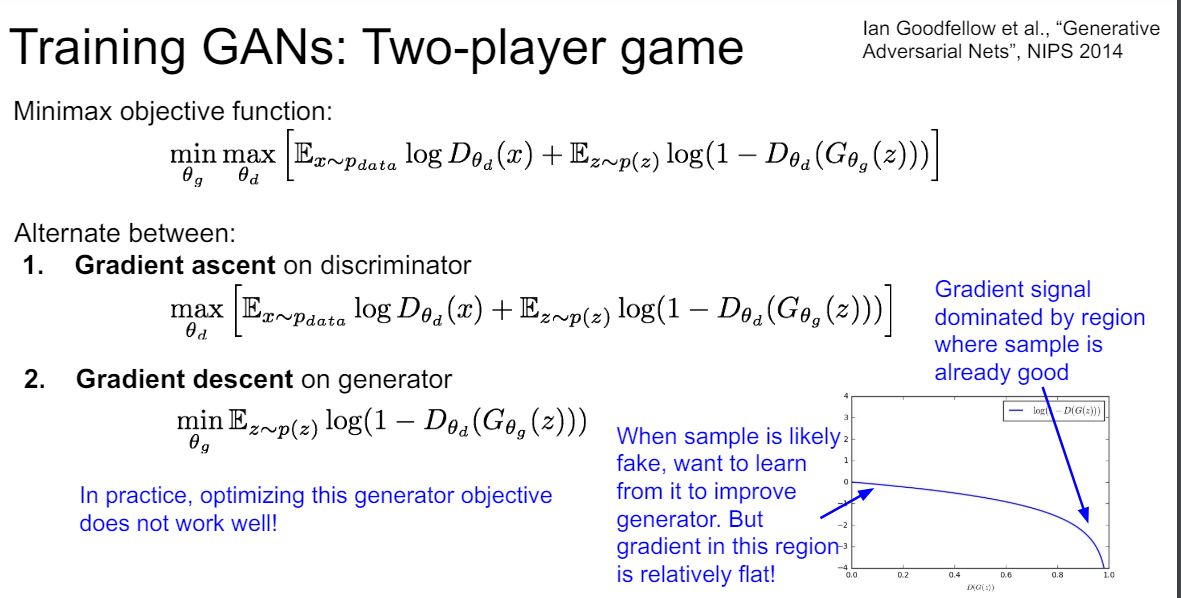

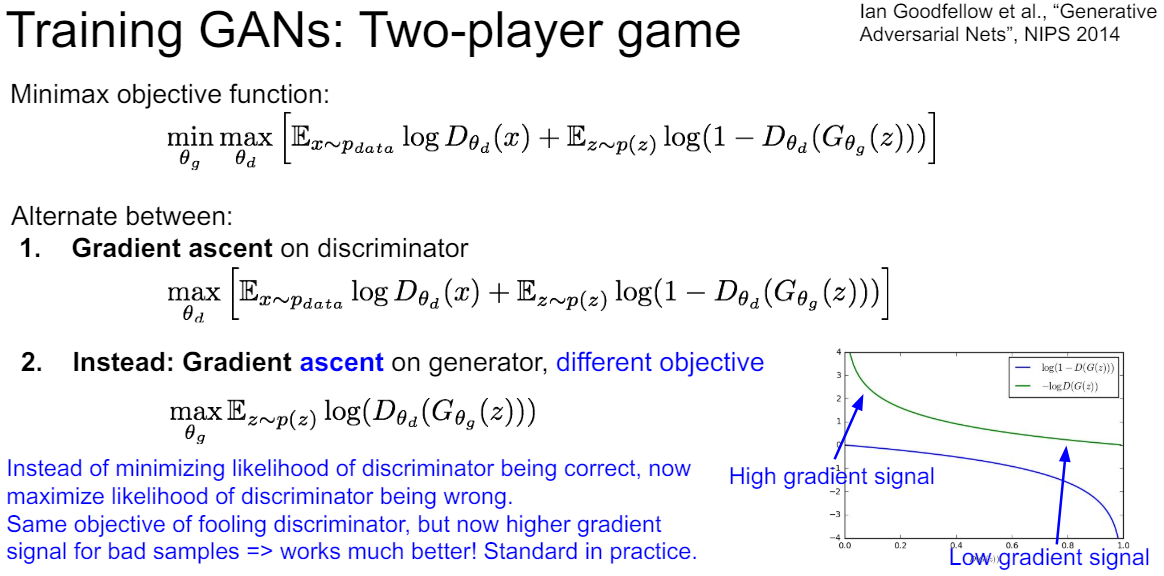

source:Fei-Fei Li & Justin Johnson & Serena Yeung L-lecture 11:GAN

### **PART3**

case A:
ourdataset is different

I used a VGG16 which trained on imagenet,tf.keras.layers.Input is used for adjusting the input of vgg16 with respect to shape of our dataset which in this case I used mnist dataset.

I didn't include the top because the dataset is not imagenet and we have to adjust the top according to our dataset

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load pre-trained model without the top (fully connected) layers

input_layer=tf.keras.layers.Input(shape=(48,48,3))
base_model=VGG16(weights='imagenet',input_tensor=input_layer,include_top=False)
for layer in base_model.layers:
    layer.trainable = False


We all know mnist has 10 classes.I flattened the model output and put a layer with relu activiation function.

In [ ]:
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(10, activation='softmax')(x)  # num_classes is the number of classes in your dataset

# Create a new model with the custom layers
model_mnist = Model(inputs=base_model.input, outputs=output)

I used mnist dataset because it is not like imagenet at all.because the model only accepts color images I used np.dstack.

np.dstack=Stack arrays in sequence depth wise (along third axis).
This function makes most sense for arrays with up to 3 dimensions. For instance, for pixel-data with a height (first axis), width (second axis), and r/g/b channels (third axis).

In [ ]:
from tensorflow.keras.datasets import mnist
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images=np.dstack([train_images] * 3)
test_images=np.dstack([test_images]*3)
train_images.shape,test_images.shape


because the dataset is big I used 10 thousand sample for training and a thousand for test

In [ ]:
train_labels=train_labels[0:10000]
test_labels=test_labels[0:1000]

In [ ]:
train_images=train_images[0:10000]
test_images=test_images[0:1000]

I need the second and third dimension of train images because i need to add 3 channels to mnist datset

In [ ]:
train_images.shape

here i reshaped the datasets for it having 3 channels

In [ ]:
train_images=train_images.reshape(-1,28,28,3)
test_images=test_images.reshape(-1,28,28,3)

here i changed the arrays to images and resize them for all the samples in training data.then I reshaped them and convert them back to arrays for the model.now the size is good for computing

In [ ]:
from keras.preprocessing.image import img_to_array, array_to_img

train_images = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in train_images])
test_images= np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in test_images])
#train_x = preprocess_input(x)
train_images.shape, test_images.shape

here we can see the model summary

In [ ]:

model_mnist.summary()


In [ ]:
model_mnist.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model using the dataset
history_vgg16_not_similar=model_mnist.fit(x=train_images,y=train_labels,validation_data=(test_images,test_labels), epochs=10,verbose=1,batch_size=500)

In [ ]:
print_accuracy(history_vgg16_not_similar)

In [ ]:
print_loss(history_vgg16_not_similar)

Ok.let's talk about the case which our dataset is small and it is simillar to the original dataset.

I used Cifar10 as my dataset and imagenet as the dataset which the model trained on like the previous case.

The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research.[1][2] The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes.[3] The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class.[4]



I loaded the cifar10 dataset using tf.keras.datasets

In [1]:
from tensorflow.keras.datasets import cifar10
(train_images, train_labels), (test_im, test_l) = cifar10.load_data()

170498071/170498071 [==============================] - 13s 0us/step


I loaded vgg16 using tf.keras.applications. I freezed the weight which model pretrained on.The model trained on Imagenet.
I used tf.keras.layers.Input to make the shape of the input of my model.I didn't include the top because I want it to train on not Imagenet dataset

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load pre-trained model without the top (fully connected) layers

input_layer=tf.keras.layers.Input(shape=(32,32,3))
base_model=VGG16(weights='imagenet',input_tensor=input_layer,include_top=False)
# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False


I flattened the output and I added some layers myself.I said earlier Cifar10 has 10 classes so we have 10 neurons at the last layer.

I used batch normalization and dropout to prevent overfitting

In [ ]:
x = Flatten()(base_model.output)
x=tf.keras.layers.Dropout(0.3)(x)
x=tf.keras.layers.BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
output = Dense(10, activation='softmax')(x)  # num_classes is the number of classes in your dataset

# Create a new model with the custom layers
model_cifar = Model(inputs=base_model.input, outputs=output)

I used early stopping for preventing overfitting and vein epochs

In [ ]:
early_stop=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.002,
    patience=20,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0,
)

I used rmsprop for optimizing and I used sparse categorical crossentropy because my labels are not one hot encoded

In [ ]:
model_cifar.compile(optimizer="rmsprop", loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model using the dataset
history_vgg16_similar=model_cifar.fit(x=train_images,y=train_labels,validation_data=(test_im,test_l), epochs=200,verbose=1,batch_size=100,callbacks=[early_stop])

As you see the model trained well and the accuracy is good.the model improves over time.the loss is decreasing and the accuracy is increasing.to be sure that the model is good we plan the learning curves

In [ ]:
print_accuracy(history_vgg16_similar)

In [ ]:
print_loss(history_vgg16_similar)

there is a small point to make.

in theory ,we should freeze less weight in the case that dataset is not similar.but as you can see my model trained fine ,freezing all the layers.

The reason that we freeze the layer is the cost of computation,becuase if we don't we have to train on more layers and learn more parameters.But if we ignore the cost of computation,still note that we do not know what filters detect in model.and that's my model worked fine with the model with all the freezed layers.

note that when our dataset is small using transfer learning is effective because it somehow increases our data